# Trained More models using XgBoost, ExtraTrees & Neural Network

In [1]:
# Core libraries
import polars as pl
import numpy as np
import pandas as pd  # Only for sklearn compatibility
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, VotingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Model Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score,
    log_loss, brier_score_loss
)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Interpretation
#import shap
from sklearn.inspection import permutation_importance

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical
from scipy import stats
from scipy.stats import chi2_contingency
import joblib

# Configuration
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [2]:
# Load the engineered dataset
print("Loading engineered dataset...")

# Load with Polars for high performance
df = pl.read_csv('notebooks/results/feature_engineering/final_engineered_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.estimated_size('mb')} MB")

# Display basic info
df.head()

Loading engineered dataset...
Dataset shape: (5110, 28)
Memory usage: 1.0149078369140625 MB


age_diabetes,cv_risk_count,age_decade,work_stress_level,hypertension_elderly,high_stress_work,hypertension,married,stroke,male_age_interaction,bmi_hypertension,age_hypertension_diabetes,bmi_glucose,heart_disease,bmi,age_high_risk,glucose_heart_disease,avg_glucose_level,gender_female,female_elderly,age_hypertension,age_obesity,age,gender_male,modifiable_risk_count,bmi_diabetes,gender_Male,gender_Other
f64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,i64,f64,f64,i64,i64,f64,f64,f64,i64,i64,f64,bool,bool
67.0,2,60.0,3,0,1,0,1,1,67.0,0.0,0.0,8370.054,1,36.6,1,228.69,228.69,0,0,0.0,67.0,67.0,1,2,36.6,true,false
61.0,1,60.0,2,0,0,0,1,1,0.0,0.0,0.0,6790.2118,0,33.58,0,0.0,202.21,1,0,0.0,61.0,61.0,0,2,33.58,false,false
0.0,1,80.0,3,0,1,0,1,1,80.0,0.0,0.0,3442.4,1,32.5,1,105.92,105.92,0,0,0.0,80.0,80.0,1,1,0.0,true,false
49.0,2,40.0,3,0,1,0,1,1,0.0,0.0,0.0,5890.312,0,34.4,0,0.0,171.23,1,0,0.0,49.0,49.0,0,3,34.4,false,false
79.0,2,70.0,2,1,0,1,1,1,0.0,24.0,79.0,4178.88,0,24.0,1,0.0,174.12,1,1,79.0,0.0,79.0,0,1,24.0,false,false


In [3]:
# Dataset overview
print("=== DATASET OVERVIEW ===")
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)-1}")  # Excluding target
print(f"Missing values: {df.null_count().sum().sum()}")

# Target variable distribution
stroke_counts = df.group_by('stroke').agg(pl.count().alias('count'))
stroke_pct = stroke_counts.with_columns(
    (pl.col('count') / stroke_counts['count'].sum() * 100).alias('percentage')
)

print("\n=== TARGET DISTRIBUTION ===")
for row in stroke_pct.iter_rows(named=True):
    print(f"Stroke {row['stroke']}: {row['count']:,} ({row['percentage']:.2f}%)")

# Class imbalance ratio
minority_class = stroke_counts.filter(pl.col('stroke') == 1)['count'][0]
majority_class = stroke_counts.filter(pl.col('stroke') == 0)['count'][0]
imbalance_ratio = majority_class / minority_class

print(f"\nClass imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"This is a {'highly' if imbalance_ratio > 10 else 'moderately'} imbalanced dataset")

=== DATASET OVERVIEW ===
Total samples: 5,110
Total features: 27
Missing values: shape: (1, 28)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ age_diabe ┆ cv_risk_c ┆ age_decad ┆ work_stre ┆ … ┆ modifiabl ┆ bmi_diabe ┆ gender_Ma ┆ gender_O │
│ tes       ┆ ount      ┆ e         ┆ ss_level  ┆   ┆ e_risk_co ┆ tes       ┆ le        ┆ ther     │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ unt       ┆ ---       ┆ ---       ┆ ---      │
│ u32       ┆ u32       ┆ u32       ┆ u32       ┆   ┆ ---       ┆ u32       ┆ u32       ┆ u32      │
│           ┆           ┆           ┆           ┆   ┆ u32       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────

In [4]:
# Prepare features and target
print("Preparing features and target...")

# Convert to pandas for sklearn compatibility
df_pd = df.to_pandas()

# Separate features and target
X = df_pd.drop('stroke', axis=1)
y = df_pd['stroke']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Feature types analysis
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
boolean_features = X.select_dtypes(include=[bool]).columns.tolist()

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Boolean features: {len(boolean_features)}")

# Display feature names for reference
print("\n=== ALL FEATURES ===")
for i, feature in enumerate(X.columns, 1):
    print(f"{i:2d}. {feature}")

Preparing features and target...
Feature matrix shape: (5110, 27)
Target vector shape: (5110,)

Numeric features: 25
Boolean features: 2

=== ALL FEATURES ===
 1. age_diabetes
 2. cv_risk_count
 3. age_decade
 4. work_stress_level
 5. hypertension_elderly
 6. high_stress_work
 7. hypertension
 8. married
 9. male_age_interaction
10. bmi_hypertension
11. age_hypertension_diabetes
12. bmi_glucose
13. heart_disease
14. bmi
15. age_high_risk
16. glucose_heart_disease
17. avg_glucose_level
18. gender_female
19. female_elderly
20. age_hypertension
21. age_obesity
22. age
23. gender_male
24. modifiable_risk_count
25. bmi_diabetes
26. gender_Male
27. gender_Other


In [5]:
# Feature correlation analysis
print("Analyzing feature correlations...")

# Calculate correlation matrix
correlation_matrix = X[numeric_features].corr()

# Find highly correlated features (> 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })

if high_corr_pairs:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
    for pair in high_corr_pairs:
        print(f"  {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
else:
    print("✅ No highly correlated features found (|r| > 0.8)")

# Correlation with target
target_correlations = X[numeric_features].corrwith(y).abs().sort_values(ascending=False)
print(f"\n=== TOP 10 FEATURES BY CORRELATION WITH TARGET ===")
for feature, corr in target_correlations.head(10).items():
    print(f"{feature:25s}: {corr:.4f}")

Analyzing feature correlations...

⚠️  Found 14 highly correlated feature pairs (|r| > 0.8):
  age_diabetes ↔ avg_glucose_level: 0.859
  age_diabetes ↔ bmi_diabetes: 0.910
  age_decade ↔ age: 0.992
  work_stress_level ↔ high_stress_work: 0.801
  hypertension ↔ bmi_hypertension: 0.966
  hypertension ↔ age_hypertension: 0.973
  male_age_interaction ↔ gender_female: -0.810
  male_age_interaction ↔ gender_male: 0.811
  bmi_hypertension ↔ age_hypertension: 0.918
  bmi_glucose ↔ avg_glucose_level: 0.872
  bmi_glucose ↔ bmi_diabetes: 0.846
  heart_disease ↔ glucose_heart_disease: 0.905
  avg_glucose_level ↔ bmi_diabetes: 0.862
  gender_female ↔ gender_male: -1.000

=== TOP 10 FEATURES BY CORRELATION WITH TARGET ===
age_high_risk            : 0.2471
age                      : 0.2453
age_decade               : 0.2409
female_elderly           : 0.1774
age_diabetes             : 0.1763
hypertension_elderly     : 0.1701
cv_risk_count            : 0.1657
glucose_heart_disease    : 0.1563
age_hypert

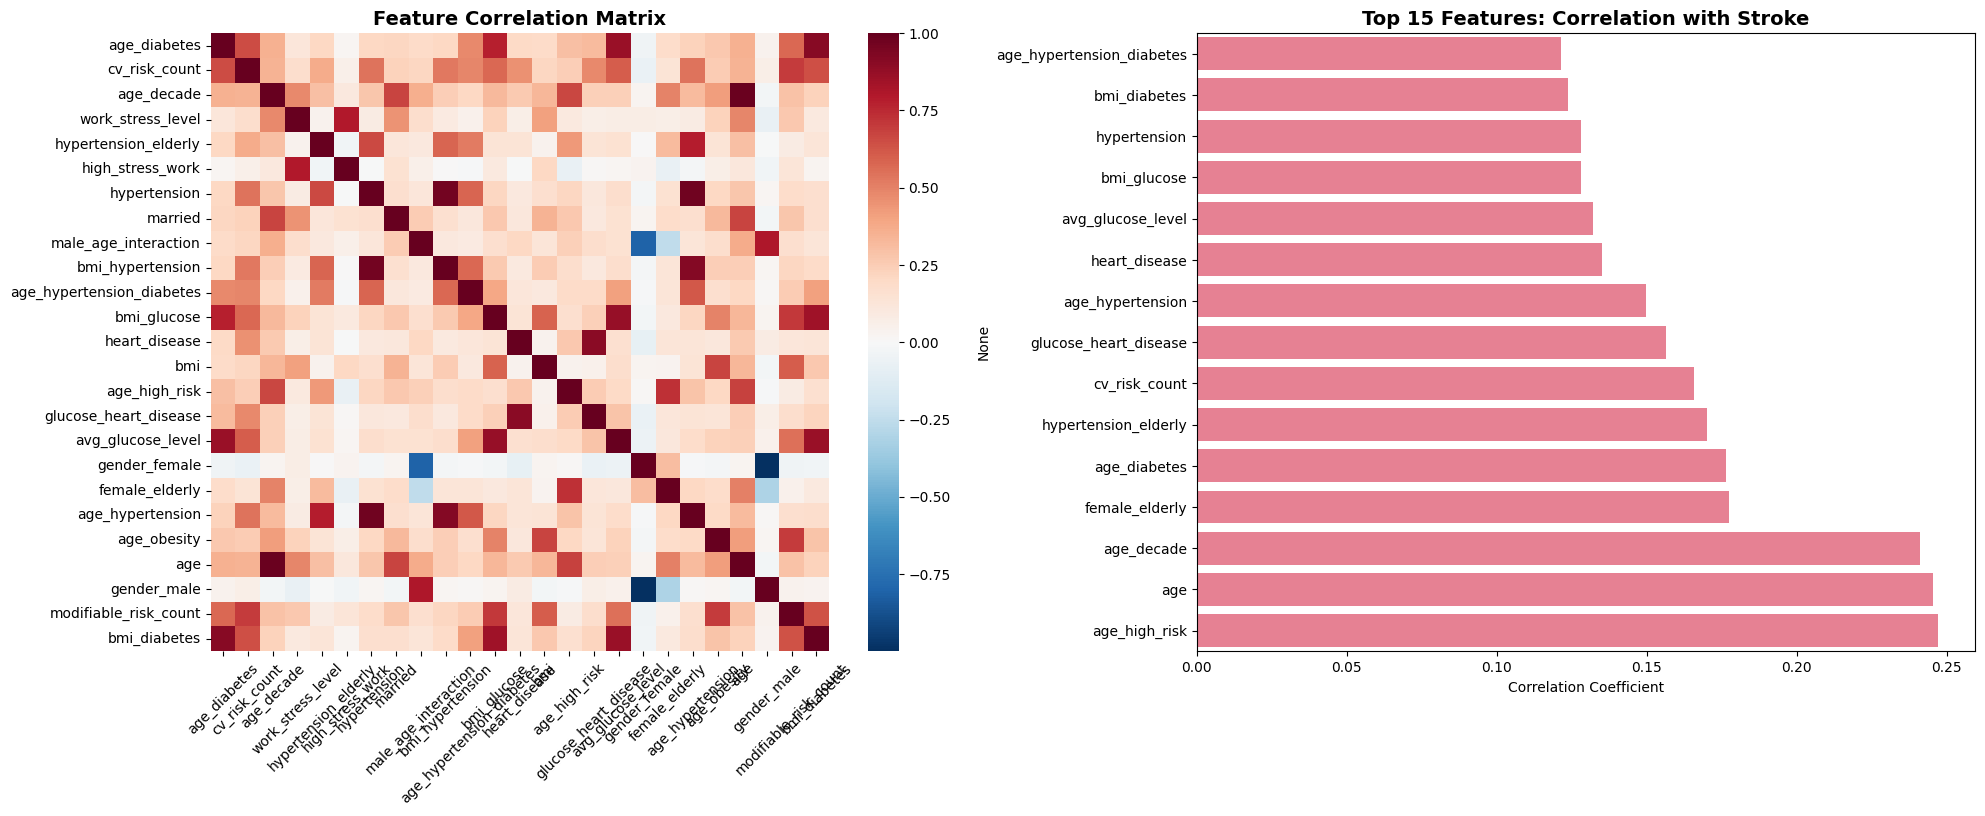

In [6]:
# Visualization: Feature correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation matrix
sns.heatmap(correlation_matrix, 
            annot=False, cmap='RdBu_r', center=0,
            square=True, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Top features correlation with target
top_features = target_correlations.head(15).index
top_corr_matrix = X[top_features].corrwith(y).sort_values(ascending=True)

sns.barplot(y=top_corr_matrix.index, x=top_corr_matrix.values, ax=axes[1])
axes[1].set_title('Top 15 Features: Correlation with Stroke', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

In [9]:
# Stratified train-test split
print("Performing stratified train-test split...")

# Initial split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Further split training into train/validation: 64% train, 16% validation, 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 0.2 * 0.8 = 0.16 of total
    random_state=42,
    stratify=y_train
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples") 
print(f"Test set: {X_test.shape[0]:,} samples")

# Check class distribution in each set
sets_info = {
    'Training': (y_train, len(y_train)),
    'Validation': (y_val, len(y_val)),
    'Test': (y_test, len(y_test))
}

print("\n=== CLASS DISTRIBUTION BY SET ===")
for set_name, (y_set, total) in sets_info.items():
    stroke_count = (y_set == 1).sum()
    no_stroke_count = (y_set == 0).sum()
    stroke_pct = stroke_count / total * 100
    
    print(f"{set_name:12s}: {stroke_count:3d} strokes ({stroke_pct:5.2f}%), "
          f"{no_stroke_count:4d} no-stroke ({100-stroke_pct:5.2f}%)")

Performing stratified train-test split...
Training set: 3,270 samples
Validation set: 818 samples
Test set: 1,022 samples

=== CLASS DISTRIBUTION BY SET ===
Training    : 159 strokes ( 4.86%), 3111 no-stroke (95.14%)
Validation  :  40 strokes ( 4.89%),  778 no-stroke (95.11%)
Test        :  50 strokes ( 4.89%),  972 no-stroke (95.11%)


In [10]:
# Feature scaling preparation
print("Setting up feature scaling...")

# Identify features that need scaling
features_to_scale = [col for col in numeric_features if col not in boolean_features]
print(f"Features to scale: {len(features_to_scale)}")
print(f"Boolean features (no scaling): {len(boolean_features)}")

# Initialize scalers
scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler()
}

# Store original feature ranges for reference
feature_ranges = {}
for feature in features_to_scale:
    feature_ranges[feature] = {
        'min': X_train[feature].min(),
        'max': X_train[feature].max(),
        'mean': X_train[feature].mean(),
        'std': X_train[feature].std()
    }

print("\n=== FEATURE STATISTICS (TRAINING SET) ===")
print(f"{'Feature':<25} {'Min':>8} {'Max':>8} {'Mean':>8} {'Std':>8}")
print("-" * 65)
for feature, stats in list(feature_ranges.items())[:10]:  # Show first 10
    print(f"{feature:<25} {stats['min']:8.2f} {stats['max']:8.2f} "
          f"{stats['mean']:8.2f} {stats['std']:8.2f}")
if len(feature_ranges) > 10:
    print(f"... and {len(feature_ranges)-10} more features")

Setting up feature scaling...
Features to scale: 25
Boolean features (no scaling): 2

=== FEATURE STATISTICS (TRAINING SET) ===
Feature                        Min      Max     Mean      Std
-----------------------------------------------------------------
age_diabetes                  0.00    82.00    10.35    22.87
cv_risk_count                 0.00     4.00     0.50     0.72
age_decade                    0.00    80.00    38.91    22.66
work_stress_level             0.00     3.00     2.29     1.02
hypertension_elderly          0.00     1.00     0.04     0.21
high_stress_work              0.00     1.00     0.57     0.49
hypertension                  0.00     1.00     0.10     0.29
married                       0.00     1.00     0.66     0.47
male_age_interaction          0.00    82.00    17.39    25.79
bmi_hypertension              0.00    97.60     3.18    10.17
... and 15 more features


In [11]:
# Define resampling strategies
print("Setting up class imbalance handling strategies...")

# Original imbalance info
original_counts = np.bincount(y_train)
print(f"Original class distribution: {original_counts[0]} : {original_counts[1]} "
      f"(ratio {original_counts[0]/original_counts[1]:.1f}:1)")

# Define resampling strategies
resampling_strategies = {
    'none': None,
    'smote': SMOTE(random_state=42),
    'borderline_smote': BorderlineSMOTE(random_state=42),
    'adasyn': ADASYN(random_state=42),
    'smote_tomek': SMOTETomek(random_state=42),
    'smote_enn': SMOTEENN(random_state=42),
}

# Test each resampling strategy
resampling_results = {}

for name, resampler in resampling_strategies.items():
    if resampler is None:
        X_resampled, y_resampled = X_train.copy(), y_train.copy()
    else:
        X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    
    counts = np.bincount(y_resampled)
    ratio = counts[0] / counts[1] if counts[1] > 0 else float('inf')
    
    resampling_results[name] = {
        'total_samples': len(y_resampled),
        'no_stroke': counts[0],
        'stroke': counts[1],
        'ratio': ratio,
        'X': X_resampled,
        'y': y_resampled
    }

print("\n=== RESAMPLING STRATEGY COMPARISON ===")
print(f"{'Strategy':<20} {'Total':>8} {'No Stroke':>10} {'Stroke':>8} {'Ratio':>8}")
print("-" * 60)
for name, results in resampling_results.items():
    print(f"{name:<20} {results['total_samples']:8,} {results['no_stroke']:10,} "
          f"{results['stroke']:8,} {results['ratio']:8.1f}")

Setting up class imbalance handling strategies...
Original class distribution: 3111 : 159 (ratio 19.6:1)

=== RESAMPLING STRATEGY COMPARISON ===
Strategy                Total  No Stroke   Stroke    Ratio
------------------------------------------------------------
none                    3,270      3,111      159     19.6
smote                   6,222      3,111    3,111      1.0
borderline_smote        6,222      3,111    3,111      1.0
adasyn                  6,251      3,111    3,140      1.0
smote_tomek             6,144      3,072    3,072      1.0
smote_enn               5,312      2,446    2,866      0.9


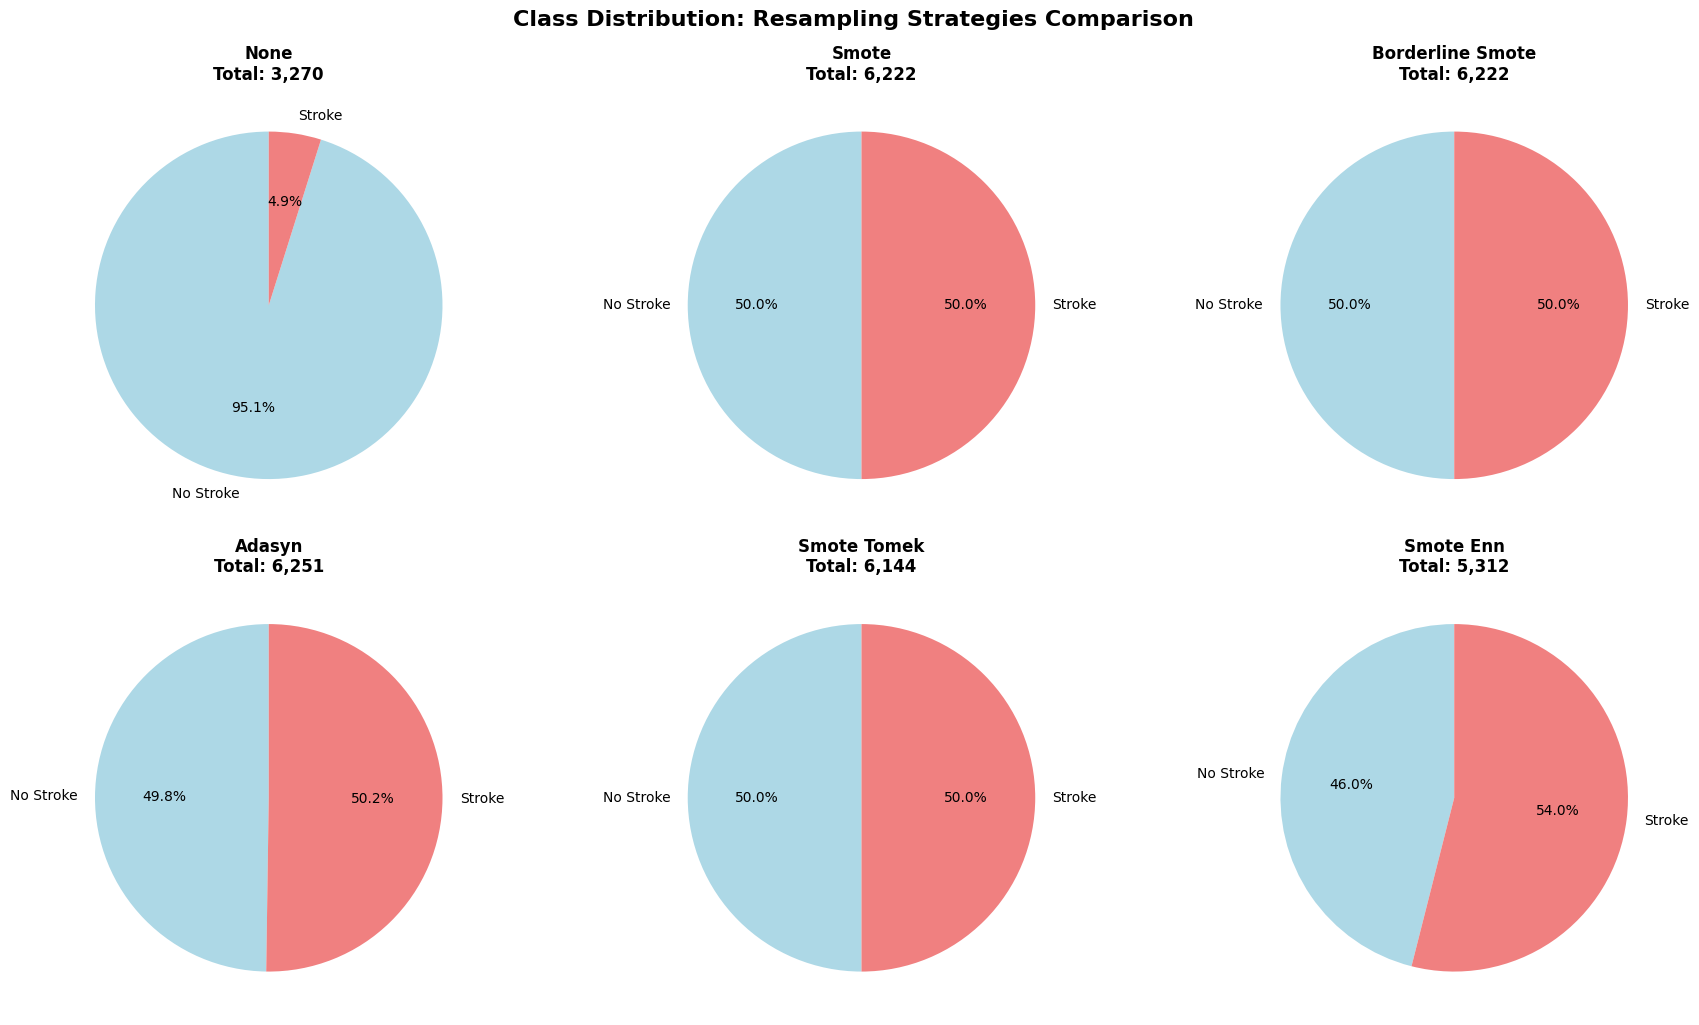

In [12]:
# Visualize class distribution before/after resampling
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (name, results) in enumerate(resampling_results.items()):
    if i >= 6:  # Limit to 6 subplots
        break
        
    counts = [results['no_stroke'], results['stroke']]
    labels = ['No Stroke', 'Stroke']
    colors = ['lightblue', 'lightcoral']
    
    axes[i].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{name.replace("_", " ").title()}\n'
                      f'Total: {results["total_samples"]:,}', 
                      fontweight='bold')

plt.tight_layout()
plt.suptitle('Class Distribution: Resampling Strategies Comparison', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Setting Up Xgboost & ExtraTrees

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

print("Setting up machine learning models...")

# Updated base models dictionary
base_models = {
    'extra_trees': {
        'model': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [False, True]
        },
        'scalers': [None]  # Tree-based models do not require scaling
    },
    
    'xgboost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'scalers': [None]  # XGBoost handles unscaled data well
    }
}

print(f"Configured {len(base_models)} base models:")
for name in base_models.keys():
    print(f"  • {name.replace('_', ' ').title()}")

Setting up machine learning models...
Configured 2 base models:
  • Extra Trees
  • Xgboost


In [18]:
# Cross-validation setup
print("Setting up cross-validation strategy...")

# Stratified K-Fold for robust evaluation
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Cross-validation: {cv_folds}-fold stratified")
print(f"Evaluation metrics: AUC, Precision, Recall, F1-Score")

# Define evaluation metrics
scoring_metrics = {
    'auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'accuracy': 'accuracy'
}

print(f"Scoring metrics: {list(scoring_metrics.keys())}")

Setting up cross-validation strategy...
Cross-validation: 5-fold stratified
Evaluation metrics: AUC, Precision, Recall, F1-Score
Scoring metrics: ['auc', 'precision', 'recall', 'f1', 'accuracy']


In [19]:
# Model training function
def train_and_evaluate_model(model_name, model_config, X_train, y_train, 
                           X_val, y_val, resampling_strategy=None, scaler_type=None):
    """
    Train and evaluate a model with optional resampling and scaling.
    """
    results = {}
    
    # Apply resampling if specified
    if resampling_strategy and resampling_strategy != 'none':
        resampler = resampling_strategies[resampling_strategy]
        X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    
    # Apply scaling if specified
    if scaler_type:
        scaler = scalers[scaler_type]
        scaler.fit(X_train_res[features_to_scale])
        
        X_train_scaled = X_train_res.copy()
        X_train_scaled[features_to_scale] = scaler.transform(X_train_res[features_to_scale])
        
        X_val_scaled = X_val.copy()
        X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
    else:
        X_train_scaled = X_train_res
        X_val_scaled = X_val
        scaler = None
    
    # Hyperparameter tuning with GridSearchCV
    model = model_config['model']
    param_grid = model_config['param_grid']
    
    # Use randomized search for large parameter spaces
    if len(param_grid) > 4 or any(len(v) > 5 for v in param_grid.values()):
        search = RandomizedSearchCV(
            model, param_grid, cv=cv_strategy, scoring='roc_auc',
            n_iter=50, random_state=42, n_jobs=-1
        )
    else:
        search = GridSearchCV(
            model, param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1
        )
    
    # Fit the search
    search.fit(X_train_scaled, y_train_res)
    
    # Best model
    best_model = search.best_estimator_
    
    # Predictions
    y_val_pred = best_model.predict(X_val_scaled)
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    results = {
        'model_name': model_name,
        'resampling': resampling_strategy or 'none',
        'scaler': scaler_type or 'none',
        'best_params': search.best_params_,
        'best_model': best_model,
        'scaler_obj': scaler,
        'auc': roc_auc_score(y_val, y_val_proba),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'accuracy': accuracy_score(y_val, y_val_pred),
        'predictions': y_val_pred,
        'probabilities': y_val_proba
    }
    
    return results

print("Model training function defined ✅")

Model training function defined ✅


In [20]:
# Execute comprehensive model training
print("🚀 Starting comprehensive model training...")
print("This may take several minutes...")

all_results = []
total_combinations = 0

# Count total combinations for progress tracking
for model_name, model_config in base_models.items():
    scalers_to_try = model_config['scalers']
    if None in scalers_to_try:
        scalers_to_try = [None]
    total_combinations += len(resampling_strategies) * len(scalers_to_try)

print(f"Total model combinations to train: {total_combinations}")

# Train all combinations
current_combination = 0

for model_name, model_config in base_models.items():
    print(f"\n--- Training {model_name.replace('_', ' ').title()} ---")
    
    scalers_to_try = model_config['scalers']
    if None in scalers_to_try:
        scalers_to_try = [None]
    
    for resampling_name in resampling_strategies.keys():
        for scaler_type in scalers_to_try:
            current_combination += 1
            
            print(f"  [{current_combination:2d}/{total_combinations}] "
                  f"Resampling: {resampling_name:<15} Scaler: {scaler_type or 'none':<10}", 
                  end=" ... ")
            
            try:
                result = train_and_evaluate_model(
                    model_name, model_config, X_train, y_train, X_val, y_val,
                    resampling_name, scaler_type
                )
                all_results.append(result)
                print(f"AUC: {result['auc']:.4f}")
                
            except Exception as e:
                print(f"FAILED: {str(e)[:50]}")

print(f"\n✅ Training completed! {len(all_results)} successful models")

🚀 Starting comprehensive model training...
This may take several minutes...
Total model combinations to train: 12

--- Training Extra Trees ---
  [ 1/12] Resampling: none            Scaler: none       ... AUC: 0.8320
  [ 2/12] Resampling: smote           Scaler: none       ... AUC: 0.7903
  [ 3/12] Resampling: borderline_smote Scaler: none       ... AUC: 0.7849
  [ 4/12] Resampling: adasyn          Scaler: none       ... AUC: 0.7876
  [ 5/12] Resampling: smote_tomek     Scaler: none       ... AUC: 0.7738
  [ 6/12] Resampling: smote_enn       Scaler: none       ... AUC: 0.8079

--- Training Xgboost ---
  [ 7/12] Resampling: none            Scaler: none       ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

AUC: 0.8411
  [ 8/12] Resampling: smote           Scaler: none       ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

AUC: 0.7934
  [ 9/12] Resampling: borderline_smote Scaler: none       ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

AUC: 0.8030
  [10/12] Resampling: adasyn          Scaler: none       ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

AUC: 0.7880
  [11/12] Resampling: smote_tomek     Scaler: none       ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

AUC: 0.7954
  [12/12] Resampling: smote_enn       Scaler: none       ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/xgboost/training.py:183: 

AUC: 0.8030

✅ Training completed! 12 successful models


In [21]:
# Results analysis and ranking
print("Analyzing model performance...")

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Resampling': r['resampling'],
        'Scaler': r['scaler'],
        'AUC': r['auc'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'Accuracy': r['accuracy']
    }
    for r in all_results
])

# Sort by AUC score
results_df = results_df.sort_values('AUC', ascending=False)

print("=== TOP 15 MODEL CONFIGURATIONS ===")
print(f"{'Rank':<4} {'Model':<20} {'Resampling':<15} {'Scaler':<10} {'AUC':<6} {'F1':<6} {'Precision':<10} {'Recall':<6}")
print("-" * 85)

for i, (_, row) in enumerate(results_df.head(15).iterrows(), 1):
    print(f"{i:<4} {row['Model']:<20} {row['Resampling']:<15} {row['Scaler']:<10} "
          f"{row['AUC']:<6.4f} {row['F1']:<6.4f} {row['Precision']:<10.4f} {row['Recall']:<6.4f}")

# Best model overall
best_result = all_results[results_df.index[0]]
print(f"\n🏆 BEST MODEL: {best_result['model_name']} "
      f"(Resampling: {best_result['resampling']}, Scaler: {best_result['scaler']})")
print(f"   AUC: {best_result['auc']:.4f}")
print(f"   Best parameters: {best_result['best_params']}")

Analyzing model performance...
=== TOP 15 MODEL CONFIGURATIONS ===
Rank Model                Resampling      Scaler     AUC    F1     Precision  Recall
-------------------------------------------------------------------------------------
1    xgboost              none            none       0.8411 0.0000 0.0000     0.0000
2    extra_trees          none            none       0.8320 0.0000 0.0000     0.0000
3    extra_trees          smote_enn       none       0.8079 0.1786 0.1389     0.2500
4    xgboost              borderline_smote none       0.8030 0.0392 0.0909     0.0250
5    xgboost              smote_enn       none       0.8030 0.1455 0.1143     0.2000
6    xgboost              smote_tomek     none       0.7954 0.0635 0.0870     0.0500
7    xgboost              smote           none       0.7934 0.0702 0.1176     0.0500
8    extra_trees          smote           none       0.7903 0.1493 0.1852     0.1250
9    xgboost              adasyn          none       0.7880 0.0377 0.0769     0.0

# Setting Up Neural Network

In [22]:

from sklearn.neural_network import MLPClassifier

print("Setting up machine learning models...")

# Base models dictionary including ExtraTrees, XGBoost, and Neural Network (MLP)
base_models = {
    
    
    'neural_network': {
        'model': MLPClassifier(random_state=42, max_iter=300),
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50), (64, 64)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        },
        'scalers': ['standard', 'robust']  # MLP needs scaled inputs
    }
}

print(f"Configured {len(base_models)} base models:")
for name in base_models.keys():
    print(f"  • {name.replace('_', ' ').title()}")

Setting up machine learning models...
Configured 1 base models:
  • Neural Network


In [23]:
# Cross-validation setup
print("Setting up cross-validation strategy...")

# Stratified K-Fold for robust evaluation
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Cross-validation: {cv_folds}-fold stratified")
print(f"Evaluation metrics: AUC, Precision, Recall, F1-Score")

# Define evaluation metrics
scoring_metrics = {
    'auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'accuracy': 'accuracy'
}

print(f"Scoring metrics: {list(scoring_metrics.keys())}")

Setting up cross-validation strategy...
Cross-validation: 5-fold stratified
Evaluation metrics: AUC, Precision, Recall, F1-Score
Scoring metrics: ['auc', 'precision', 'recall', 'f1', 'accuracy']


In [24]:
# Model training function
def train_and_evaluate_model(model_name, model_config, X_train, y_train, 
                           X_val, y_val, resampling_strategy=None, scaler_type=None):
    """
    Train and evaluate a model with optional resampling and scaling.
    """
    results = {}
    
    # Apply resampling if specified
    if resampling_strategy and resampling_strategy != 'none':
        resampler = resampling_strategies[resampling_strategy]
        X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
    
    # Apply scaling if specified
    if scaler_type:
        scaler = scalers[scaler_type]
        scaler.fit(X_train_res[features_to_scale])
        
        X_train_scaled = X_train_res.copy()
        X_train_scaled[features_to_scale] = scaler.transform(X_train_res[features_to_scale])
        
        X_val_scaled = X_val.copy()
        X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
    else:
        X_train_scaled = X_train_res
        X_val_scaled = X_val
        scaler = None
    
    # Hyperparameter tuning with GridSearchCV
    model = model_config['model']
    param_grid = model_config['param_grid']
    
    # Use randomized search for large parameter spaces
    if len(param_grid) > 4 or any(len(v) > 5 for v in param_grid.values()):
        search = RandomizedSearchCV(
            model, param_grid, cv=cv_strategy, scoring='roc_auc',
            n_iter=50, random_state=42, n_jobs=-1
        )
    else:
        search = GridSearchCV(
            model, param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1
        )
    
    # Fit the search
    search.fit(X_train_scaled, y_train_res)
    
    # Best model
    best_model = search.best_estimator_
    
    # Predictions
    y_val_pred = best_model.predict(X_val_scaled)
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    results = {
        'model_name': model_name,
        'resampling': resampling_strategy or 'none',
        'scaler': scaler_type or 'none',
        'best_params': search.best_params_,
        'best_model': best_model,
        'scaler_obj': scaler,
        'auc': roc_auc_score(y_val, y_val_proba),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'accuracy': accuracy_score(y_val, y_val_pred),
        'predictions': y_val_pred,
        'probabilities': y_val_proba
    }
    
    return results

print("Model training function defined ✅")

Model training function defined ✅


In [25]:
# Execute comprehensive model training
print("🚀 Starting comprehensive model training...")
print("This may take several minutes...")

all_results = []
total_combinations = 0

# Count total combinations for progress tracking
for model_name, model_config in base_models.items():
    scalers_to_try = model_config['scalers']
    if None in scalers_to_try:
        scalers_to_try = [None]
    total_combinations += len(resampling_strategies) * len(scalers_to_try)

print(f"Total model combinations to train: {total_combinations}")

# Train all combinations
current_combination = 0

for model_name, model_config in base_models.items():
    print(f"\n--- Training {model_name.replace('_', ' ').title()} ---")
    
    scalers_to_try = model_config['scalers']
    if None in scalers_to_try:
        scalers_to_try = [None]
    
    for resampling_name in resampling_strategies.keys():
        for scaler_type in scalers_to_try:
            current_combination += 1
            
            print(f"  [{current_combination:2d}/{total_combinations}] "
                  f"Resampling: {resampling_name:<15} Scaler: {scaler_type or 'none':<10}", 
                  end=" ... ")
            
            try:
                result = train_and_evaluate_model(
                    model_name, model_config, X_train, y_train, X_val, y_val,
                    resampling_name, scaler_type
                )
                all_results.append(result)
                print(f"AUC: {result['auc']:.4f}")
                
            except Exception as e:
                print(f"FAILED: {str(e)[:50]}")

print(f"\n✅ Training completed! {len(all_results)} successful models")

🚀 Starting comprehensive model training...
This may take several minutes...
Total model combinations to train: 12

--- Training Neural Network ---
  [ 1/12] Resampling: none            Scaler: standard   ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.8430
  [ 2/12] Resampling: none            Scaler: robust     ... AUC: 0.8448
  [ 3/12] Resampling: smote           Scaler: standard   ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.6846
  [ 4/12] Resampling: smote           Scaler: robust     ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7159
  [ 5/12] Resampling: borderline_smote Scaler: standard   ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7182
  [ 6/12] Resampling: borderline_smote Scaler: robust     ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7745
  [ 7/12] Resampling: adasyn          Scaler: standard   ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7107
  [ 8/12] Resampling: adasyn          Scaler: robust     ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7109
  [ 9/12] Resampling: smote_tomek     Scaler: standard   ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.6839
  [10/12] Resampling: smote_tomek     Scaler: robust     ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7305
  [11/12] Resampling: smote_enn       Scaler: standard   ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7208
  [12/12] Resampling: smote_enn       Scaler: robust     ... 

/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sourangshupal/Downloads/Module1_FinalProject/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic 

AUC: 0.7444

✅ Training completed! 12 successful models


In [26]:
# Results analysis and ranking
print("Analyzing model performance...")

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Resampling': r['resampling'],
        'Scaler': r['scaler'],
        'AUC': r['auc'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'Accuracy': r['accuracy']
    }
    for r in all_results
])

# Sort by AUC score
results_df = results_df.sort_values('AUC', ascending=False)

print("=== TOP 15 MODEL CONFIGURATIONS ===")
print(f"{'Rank':<4} {'Model':<20} {'Resampling':<15} {'Scaler':<10} {'AUC':<6} {'F1':<6} {'Precision':<10} {'Recall':<6}")
print("-" * 85)

for i, (_, row) in enumerate(results_df.head(15).iterrows(), 1):
    print(f"{i:<4} {row['Model']:<20} {row['Resampling']:<15} {row['Scaler']:<10} "
          f"{row['AUC']:<6.4f} {row['F1']:<6.4f} {row['Precision']:<10.4f} {row['Recall']:<6.4f}")

# Best model overall
best_result = all_results[results_df.index[0]]
print(f"\n🏆 BEST MODEL: {best_result['model_name']} "
      f"(Resampling: {best_result['resampling']}, Scaler: {best_result['scaler']})")
print(f"   AUC: {best_result['auc']:.4f}")
print(f"   Best parameters: {best_result['best_params']}")

Analyzing model performance...
=== TOP 15 MODEL CONFIGURATIONS ===
Rank Model                Resampling      Scaler     AUC    F1     Precision  Recall
-------------------------------------------------------------------------------------
1    neural_network       none            robust     0.8448 0.0000 0.0000     0.0000
2    neural_network       none            standard   0.8430 0.0000 0.0000     0.0000
3    neural_network       borderline_smote robust     0.7745 0.1069 0.0769     0.1750
4    neural_network       smote_enn       robust     0.7444 0.1353 0.0968     0.2250
5    neural_network       smote_tomek     robust     0.7305 0.1020 0.0862     0.1250
6    neural_network       smote_enn       standard   0.7208 0.2074 0.1474     0.3500
7    neural_network       borderline_smote standard   0.7182 0.1443 0.1228     0.1750
8    neural_network       smote           robust     0.7159 0.1176 0.0886     0.1750
9    neural_network       adasyn          robust     0.7109 0.1143 0.0923     0.